In [38]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
from glob import glob
import numpy as np
import warnings
warnings.filterwarnings("always")
import matplotlib.pyplot as plt
import time
import yaml
import json
from tqdm import tqdm
from ccd.cell_center_detection import BM_CCD

import torch
import torchvision.utils as vutils
from torchviz import make_dot, make_dot_from_trace

from utils.const import StainChannel, ModelType, Phase, Dataset
from analysis.morphologyPredictor import MorphologyPredictor, build_args
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

# COLOR
N = 256
rd = np.ones((N, 4))
rd[:, 0] = np.linspace(255/256, 0, N) # R = 255
rd[:, 1] = np.linspace(0, 0, N) # G = 232
rd[:, 2] = np.linspace(255/256, 0, N)  # B = 11
rd_cmp = ListedColormap(rd)
rd_cmp_r = rd_cmp.reversed()
gd = np.ones((N, 4))
gd[:, 0] = np.linspace(0, 0, N) # R = 255
gd[:, 1] = np.linspace(255/256, 0, N) # G = 232
gd[:, 2] = np.linspace(255/256, 0, N)  # B = 11
gd_cmp = ListedColormap(gd)
gd_cmp_r = gd_cmp.reversed()

bd = np.ones((N, 4))
bd[:, 0] = np.linspace(255/256, 0, N) # R = 232
bd[:, 1] = np.linspace(0, 0, N) # G = 11
bd[:, 2] = np.linspace(255/256, 0, N)  # B = 255
bd_cmp = ListedColormap(bd)
bd_cmp_r = bd_cmp.reversed()

/var/internal_tools/anaconda3/envs/chunglab-repo/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Load models

In [3]:
modelpf = '/home/minykim/cbm/src/gui/MorPheT/models/models.json'
savepath = '/media/ssdshare2/general/MYK/data/analysis/notebook/PNGs'

with open(modelpf, 'r') as fp:
    model_dict = json.load(fp)
print("models: ", model_dict.keys())
#the_model = 'BMTR-20190312-170708-bumblebee'
the_model = 'ALTR-20210914-234831-bumblebee'
model_p = model_dict[the_model]
model_p

models:  dict_keys(['BMTR-20190312-170708-bumblebee', 'BMTR-20181022-185608-bumblebee', '20200705-130651-bumblebee', 'ALTR-20210914-234831-bumblebee', 'ALTR-20240202-163643-bumblebee'])


/var/internal_tools/anaconda3/envs/chunglab-repo/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'model_file': '/media/share12/MYK/models/microglia/20210914-234831-bumblebee/ALTR_AE_00063.pth',
 'net_type': 'ALTR',
 'train_data': 'microglia_labeled',
 'train_data_path': '/data_ssd/brain_mapping/training_data/cc/031219',
 'num_class': 3,
 'class': {'0': 'ramified', '1': 'amoeboid', '2': 'garbage'},
 'desc': '[data_w]: 32 [data_h]: 32 [data_d]: 16 [batch_size]: 8, [ae_weights]: None [epoch]: 100 [clustering_epoch]: 100 [num_clusters]: 3 [model_type]: ALTR [description]: DSET:031219_DESC:test',
 'version': 1.0}

In [4]:
dname = 'CKp25_45110'
wds = {
        'CKp25_45110': '/media/share/MYK/beegfs/found/CKp25_45110',
        'CK_43992': '/media/ssdshare2/general/MYK/data/TsaiLab_data/20211111_15_37_13_AD_CK_LH_43992_10x_561LP65_642LP80'
      }
wd = wds[dname]

paramf = os.path.join(wd, 'params.json')
with open(paramf, 'r') as fp:
    params = json.load(fp)
params.keys()

/var/internal_tools/anaconda3/envs/chunglab-repo/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dict_keys(['IBA1', 'NeuN', 'age', 'align_info', 'channels', 'd_raw', 'd_root', 'dd', 'dh', 'dw', 'file_ext', 'full_inference', 'inf_patch_size', 'inf_rel_path', 'marker', 'name', 'owner', 'voxel_size', 'xr', 'yr', 'zr'])

In [5]:
ccd = BM_CCD(params, params['marker'], 0, damp=0)

/var/internal_tools/anaconda3/envs/chunglab-repo/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Cell Center Annotation file (/media/share/MYK/beegfs/found/CKp25_45110/cell_centers.npy) doesn't exist! resetting to None.
[---------- DataGenParams() Variables and their values (BEGIN) ----------]
[ ann_cell_center ]	: None
[ ann_neg ]	: None
[ ann_pos ]	: None
[ csz_half ]	: 16
[ csz_quart ]	: 8
[ d_root ]	: /media/share/MYK/beegfs/found/CKp25_45110
[ data_depth ]	: 3000
[ data_height ]	: 11418
[ data_path ]	: /media/share/MYK/beegfs/found/CKp25_45110/Ex_561_Em_1_destriped_stitched_downsampled2x
[ data_rel_path ]	: Ex_561_Em_1_destriped_stitched_downsampled2x
[ data_type ]	: test
[ data_width ]	: 6233
[ debug ]	: True
[ do_not_save ]	: False
[ file_ext ]	: tiff
[ multi_channel ]	: None
[ num_cpu ]	: 10
[ num_samples ]	: 10
[ save_path ]	: /media/share/MYK/beegfs/found/CKp25_45110/inference/PIPELINE_test
[ timestmp ]	: PIPELINE
[---------- DataGenParams() Variables and their values (END) ----------]
multi channel? None
self.files[0]:  /media/share/MYK/beegfs/found/CKp25_45110/Ex_561_E

reading file:   0%|          | 0/30 [00:00<?, ?it/s]

Total 0 positive / 0 negative cell centers available from /media/share/MYK/beegfs/found/CKp25_45110/cell_centers_IBA1.npy (1619865 samples)
Availablity: 0.000%


reading file: 100%|██████████| 30/30 [00:32<00:00,  1.09s/it]


24342 / 1619865 selected


In [6]:
# load parameters from .json file
params, \
argsByChn, \
gargs, \
ranges, \
cc_csv, \
full_inference, \
clim = build_args(params['marker'], checkpoint=None, params_f=paramf)
in_memory = False
cc_csv

channel:  IBA1


/var/internal_tools/anaconda3/envs/chunglab-repo/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'/media/share/MYK/beegfs/found/CKp25_45110/cell_centers_IBA1.csv'

In [7]:
# create predictor
mp = MorphologyPredictor(title="MorphologyPredictor", keys='interactive',
                         size=(800, 600), show=True, logWindow=None,
                         gargs=gargs, margs=argsByChn, ranges=ranges,
                         in_memory=True, cc_csv=cc_csv)

mp.setup_dg(ranges=ranges, ccd=ccd)

/var/internal_tools/anaconda3/envs/chunglab-repo/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


in_memory?  True

xdpyinfo:  unable to open display "localhost:10.0".




Can't open display localhost:10.0



/var/internal_tools/anaconda3/envs/chunglab-repo/lib/python3.7/site-packages/vispy/app/backends/ipython/_widget.py:61: DeprecationWarning: metadata {'value': True} was set from the constructor. With traitlets 4.1, metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  resizable = Bool(value=True).tag(sync=True)


In [8]:
patch_sz = params['inf_patch_size']
args_infer = ['morphologyPredictor', '-ph', Phase.REALTIME,
                '-bs', '32', '-e', '2',
                '-ts', Phase.REALTIME, '-nc', str(model_p['num_class']),
                '-ds', Dataset.REALTIME, '-us', 'False', '-usv', 'False',
                '-dw', str(patch_sz[2]), '-dh', str(patch_sz[1]),
                '-dd', str(patch_sz[0]),
                '-aw', model_p['model_file'],
                #'-dp', './'mp.get_save_path(), '-ie', 'True',
                '-dp', './', '-ie', 'True',
                '-mt', model_p['net_type'], '--debug']
print("args_infer: ", args_infer)
mp.setup_model(args_infer, params['full_inference'])
mp.load_data(clim=params[params['marker']]['clim'])

args_infer:  ['morphologyPredictor', '-ph', 'realtime', '-bs', '32', '-e', '2', '-ts', 'realtime', '-nc', '3', '-ds', 'realtime', '-us', 'False', '-usv', 'False', '-dw', '32', '-dh', '32', '-dd', '16', '-aw', '/media/share12/MYK/models/microglia/20210914-234831-bumblebee/ALTR_AE_00063.pth', '-dp', './', '-ie', 'True', '-mt', 'ALTR', '--debug']
multi channel? None
self.files[0]:  /media/share/MYK/beegfs/found/CKp25_45110/Ex_561_Em_1_destriped_stitched_downsampled2x/img_0000.tiff
3000 files are retrieved from /media/share/MYK/beegfs/found/CKp25_45110/Ex_561_Em_1_destriped_stitched_downsampled2x
zr, yr, xr:  [1000, 1030] [300, 10500] [0, 5500]
self.files[0]:  /media/share/MYK/beegfs/found/CKp25_45110/Ex_561_Em_1_destriped_stitched_downsampled2x/img_0000.tiff


/var/internal_tools/anaconda3/envs/chunglab-repo/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


img.shape:  (3000, 11418, 6233)
roi.shape:  (30, 10200, 5500)
Total 0 positive / 0 negative cell centers available from /media/share/MYK/beegfs/found/CKp25_45110/cell_centers_IBA1.npy (1619865 samples)
Availablity: 0.000%
24342 / 1619865 selected
form_data(): # of coordinates within zr([1000, 1030]), yr([300, 10500]), xr([0, 5500]): 24342


In [9]:
mp.predict(params['full_inference'], False, True) 

/var/internal_tools/anaconda3/envs/chunglab-repo/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


save array?  False
save label?  True
model_name:  ALTR
self.csv_pred_name:  ALTR-20210914-234831
len(df_not_labeled):  0
Every centroid is already labeled! Directly visualizing stuff..
[Morphology Predictor] retrieving predictions for class 0
10135 / 707850 selected
[Morphology Predictor] retrieving predictions for class 1
156 / 26628 selected
[Morphology Predictor] retrieving predictions for class 2
14051 / 885387 selected


### Volume

In [10]:
print(mp.mVol.shape)
d, h, w = mp.mVol.shape
max_zproj = np.zeros((h, w))
for i in tqdm(range(h)):
    for j in range(w):
        max_zproj[i][j] = np.max(mp.mVol[:, i, j])
np.min(max_zproj), np.max(max_zproj)

/var/internal_tools/anaconda3/envs/chunglab-repo/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 4/10200 [00:00<04:38, 36.57it/s]

(30, 10200, 5500)


100%|██████████| 10200/10200 [03:43<00:00, 45.68it/s]


(0.0, 65485.0)

### Heatmap

In [43]:
def create_heatmap(cells, vol_size, heatmap_size):
    d, h, w = vol_size
    bh, bw = heatmap_size
    heatmap = np.zeros((int(np.ceil(h/bh))+1, int(np.ceil(w/bw))+1))
    
    for c in cells:
        by, bx = [int(np.ceil(c[1]/bh)), int(np.ceil(c[2]/bw))]
        heatmap[by][bx] += 1
        
    return heatmap
    
ramifieds = mp.prediction_points[0]
amoeboids = mp.prediction_points[1]
others = mp.prediction_points[2]
print(len(ramifieds), len(amoeboids), len(others))

vol_size = mp.mVol.shape
bh, bw = [150, 150]
heatmap_r =  create_heatmap(ramifieds, vol_size, (bh, bw))
heatmap_a =  create_heatmap(amoeboids, vol_size, (bh, bw))
heatmap_o =  create_heatmap(others, vol_size, (bh, bw))
print(heatmap_r.shape)
print(np.max(heatmap_r), np.max(heatmap_a), np.max(heatmap_o))

10135 156 14051
(69, 38)
21.0 6.0 37.0


/var/internal_tools/anaconda3/envs/chunglab-repo/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/var/internal_tools/anaconda3/envs/chunglab-repo/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


figf:  /media/ssdshare2/general/MYK/data/analysis/notebook/PNGs/CKp25_45110_phenotype_heatmap_3cols.png
fig saved


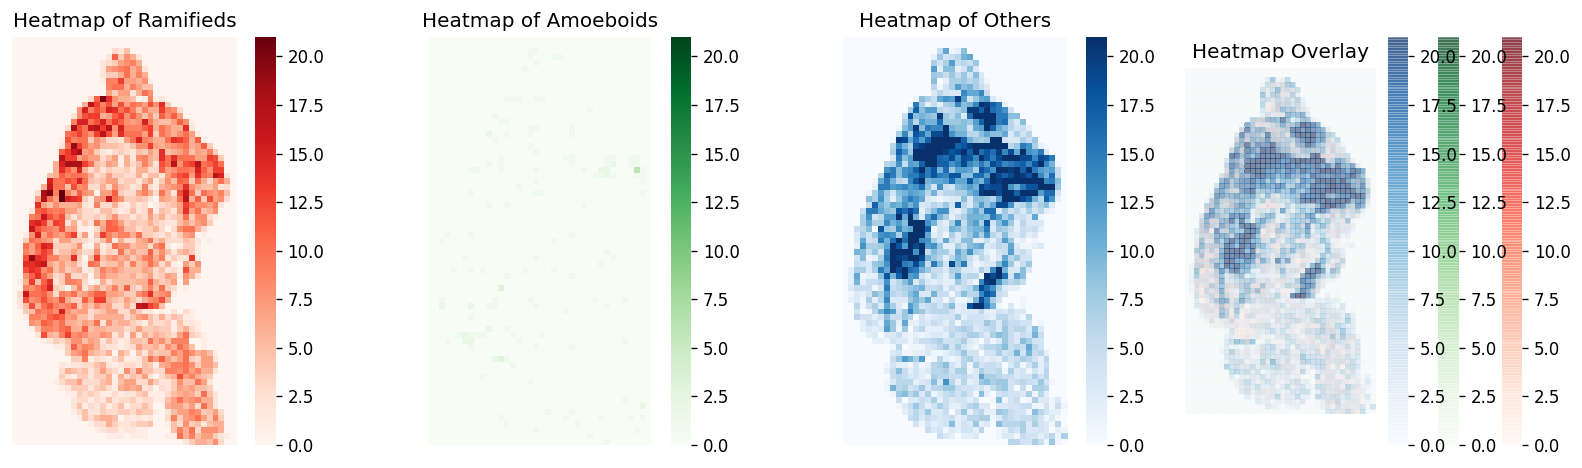

In [49]:
import seaborn as sns
vmin=0
vmax=max(np.max(heatmap_r), np.max(heatmap_a))

fig, axes = plt.subplots(figsize=(14,4), ncols=4, nrows=1, dpi=120)
r = sns.heatmap(heatmap_r, cmap='Reds', vmin=vmin, vmax=vmax, ax=axes[0])
r.set_title("Heatmap of Ramifieds")
r = sns.heatmap(heatmap_a, cmap='Greens', vmin=vmin, vmax=vmax, ax=axes[1])
r.set_title("Heatmap of Amoeboids")
r = sns.heatmap(heatmap_o, cmap='Blues', vmin=vmin, vmax=vmax, ax=axes[2])
r.set_title("Heatmap of Others")
r = sns.heatmap(heatmap_r, cmap='Reds', alpha=0.5, vmin=vmin, vmax=vmax, ax=axes[3])
r = sns.heatmap(heatmap_a, cmap='Greens', alpha=0.5, vmin=vmin, vmax=vmax, ax=axes[3])
r = sns.heatmap(heatmap_o, cmap='Blues', alpha=0.5, vmin=vmin, vmax=vmax, ax=axes[3])
r.set_title("Heatmap Overlay")
for aax in axes:
    aax.axis('off')
    aax.set_aspect('equal')
fig.tight_layout()
figf = os.path.join(savepath,  "%s_phenotype_heatmap_3cols.png"%dname)
print("figf: ", figf)
fig.savefig(figf)
print("fig saved")
plt.show()

### Z-Projection

In [45]:
print(max_zproj.shape)
import cv2
heatmap_r_exp = cv2.resize(heatmap_r, max_zproj.shape[::-1], interpolation=cv2.INTER_AREA)
heatmap_a_exp = cv2.resize(heatmap_a, max_zproj.shape[::-1], interpolation=cv2.INTER_AREA)
heatmap_o_exp = cv2.resize(heatmap_o, max_zproj.shape[::-1], interpolation=cv2.INTER_AREA)

/var/internal_tools/anaconda3/envs/chunglab-repo/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(10200, 5500)


/var/internal_tools/anaconda3/envs/chunglab-repo/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


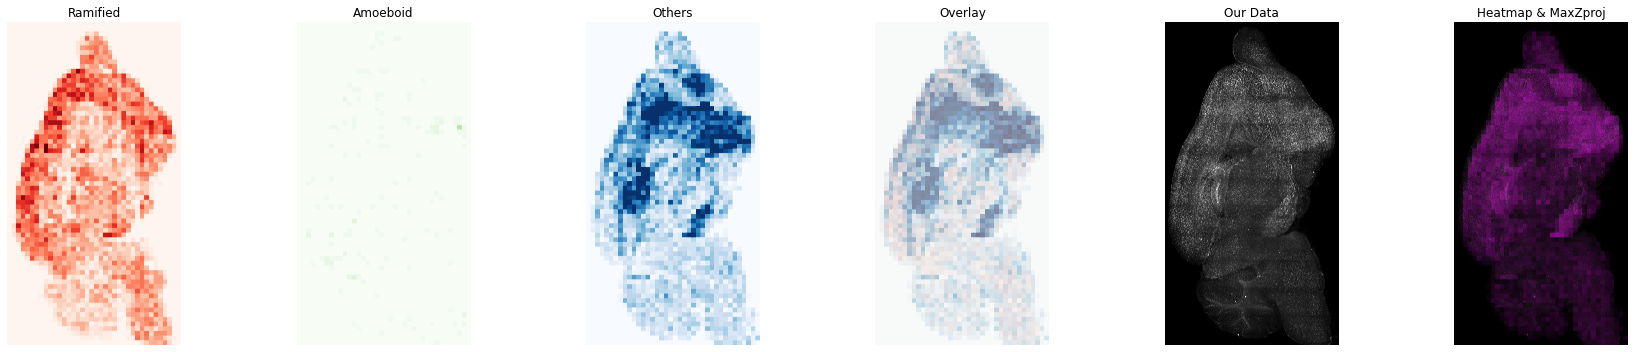

In [51]:
fig, ax = plt.subplots(figsize=(25,5), nrows=1, ncols=6)

if False:
    r = sns.heatmap(heatmap_r_exp, cmap='Reds', vmin=vmin, vmax=vmax, ax=ax[0])
    r.set_title("Ramified")
    r = sns.heatmap(heatmap_a_exp, cmap='Greens', vmin=vmin, vmax=vmax, ax=ax[1])
    r.set_title("Amoeboid")
    r = sns.heatmap(heatmap_r_exp, cmap='Reds', vmin=vmin, vmax=vmax, ax=ax[2], alpha=0.5)
    r = sns.heatmap(heatmap_a_exp, cmap='Greens', vmin=vmin, vmax=vmax, ax=ax[2], alpha=0.5)
    r.set_title("Overlay")
elif False:
    ax[0].imshow(heatmap_r_exp, cmap='Reds')#, clim=[vmin,vmax])
    ax[0].set_title("Ramified")
    ax[1].imshow(heatmap_a_exp, cmap='Greens')#, clim=[vmin,vmax])
    ax[1].set_title("Amoeboid")
    ax[2].imshow(heatmap_o_exp, cmap='Blues')#, clim=[vmin,vmax])
    ax[2].set_title("Others")
    ax[3].imshow(heatmap_r_exp, cmap='Reds')#, clim=[vmin,vmax], alpha=0.5)
    ax[3].imshow(heatmap_a_exp, cmap='Greens')#, clim=[vmin,vmax], alpha=0.5)
    ax[3].imshow(heatmap_o_exp, cmap='Blues')#, clim=[vmin,vmax], alpha=0.5)
    ax[3].set_title("Overlay")
else:
    ax[0].imshow(heatmap_r_exp, cmap='Reds', vmin=vmin, vmax=vmax)
    ax[0].set_title("Ramified")
    ax[1].imshow(heatmap_a_exp, cmap='Greens', vmin=vmin, vmax=vmax)
    ax[1].set_title("Amoeboid")
    ax[2].imshow(heatmap_o_exp, cmap='Blues', vmin=vmin, vmax=vmax)
    ax[2].set_title("Others")
    ax[3].imshow(heatmap_r_exp, cmap='Reds', vmin=vmin, vmax=vmax, alpha=0.5)
    ax[3].imshow(heatmap_a_exp, cmap='Greens', vmin=vmin, vmax=vmax, alpha=0.5)
    ax[3].imshow(heatmap_o_exp, cmap='Blues', vmin=vmin, vmax=vmax, alpha=0.5)
    ax[3].set_title("Overlay")

    
raw_dnr = [ 800, 30000 ] 
ax[4].imshow(max_zproj, clim=raw_dnr, cmap='gray')
ax[4].set_title("Our Data")
ax[5].imshow(max_zproj, clim=raw_dnr, cmap='gray')
ax[5].imshow(heatmap_r_exp, clim=[vmin, vmax], cmap=rd_cmp_r, alpha=0.5)
ax[5].imshow(heatmap_a_exp, clim=[vmin, vmax], cmap=gd_cmp_r, alpha=0.3)
ax[5].imshow(heatmap_o_exp, clim=[vmin, vmax], cmap=bd_cmp_r, alpha=0.3)
ax[5].set_title("Heatmap & MaxZproj")

for aax in ax:
    aax.axis('off')
    aax.set_aspect('equal')
fig.tight_layout()
plt.show()

In [52]:
fig.savefig(os.path.join(savepath, "%s_phenotype_heatmap.png"%dname))

/var/internal_tools/anaconda3/envs/chunglab-repo/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
